# Shortest path with time constraints and lagrangian relaxation

![title](img/ej9.png)

1. For #EX11 and T ≤ 8 hs. apply the Lagrangian Relaxation method and find a solution iterating for different values of lagrangian multipliers (λ) between 0 and 1.
1. Plot all the objective function primal solutions for the set of lagrangian multipliers used in 1).
1. What should be the optimum λ related to the shortest path solution?

# Import modules and libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog

import matplotlib.pyplot as plt

from mis_utils import *

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.latex.repr = True

## Set connections and get matrices

In [2]:
# Definiciones de constantes

node_names = np.array(('s', '2','3', '4', '5', 't'))

NN_dist = np.zeros((node_names.shape[0], node_names.shape[0]))
NN_time = np.zeros((node_names.shape[0], node_names.shape[0]))

# b = np.zeros((node_names.shape))
beq = np.zeros((node_names.shape))
beq[0]=1
beq[-1]=-1
T1 = 9
T2 = 8

In [3]:
connect_nodes(NN_dist, node_names, 's', '2', 2)
connect_nodes(NN_time, node_names, 's', '2', 3)

connect_nodes(NN_dist, node_names, '2', '4', 2)
connect_nodes(NN_time, node_names, '2', '4', 3)

connect_nodes(NN_dist, node_names, '4', 't', 1)
connect_nodes(NN_time, node_names, '4', 't', 3)

connect_nodes(NN_dist, node_names, '2', 't', 5)
connect_nodes(NN_time, node_names, '2', 't', 1)

connect_nodes(NN_dist, node_names, 's', '3', 1)
connect_nodes(NN_time, node_names, 's', '3', 1)

connect_nodes(NN_dist, node_names, '3', '5', 2)
connect_nodes(NN_time, node_names, '3', '5', 3)

connect_nodes(NN_dist, node_names, '5', 't', 2)
connect_nodes(NN_time, node_names, '5', 't', 5)

In [4]:
NN = ((NN_dist!=0) | (NN_time!=0)!=0).astype(int)
pd.DataFrame((NN!=0).astype(int), columns=node_names, index=node_names)

,s,2,3,4,5,t
s,0,1,1,0,0,0
2,0,0,0,1,0,1
3,0,0,0,0,1,0
4,0,0,0,0,0,1
5,0,0,0,0,0,1
t,0,0,0,0,0,0


In [5]:
print("They are {} connections".format((NN!=0).astype(int).sum().sum()))

They are 7 connections


## Convert to solvable data

In [6]:
Aeq, arc_idxs = nn2na(NN_dist, node_names = node_names, show_results = False)

nan_names = get_col_names(NN, node_names, as_numpy=True, sep = "->")

print("Aeq:")
display(pd.DataFrame(Aeq, index=node_names, columns=nan_names))

Aeq:


,s->2,s->3,2->4,2->t,3->5,4->t,5->t
s,1,1,0,0,0,0,0
2,-1,0,1,1,0,0,0
3,0,-1,0,0,1,0,0
4,0,0,-1,0,0,1,0
5,0,0,0,0,-1,0,1
t,0,0,0,-1,0,-1,-1


In [7]:
t = get_costs(NN_time, arc_idxs)
display(pd.DataFrame([t], index=['t'], columns=nan_names))
costs = get_costs(NN_dist, arc_idxs)
display(pd.DataFrame([costs], index=['C'], columns=nan_names))

,s->2,s->3,2->4,2->t,3->5,4->t,5->t
t,3.0,1.0,3.0,1.0,3.0,3.0,5.0


,s->2,s->3,2->4,2->t,3->5,4->t,5->t
C,2.0,1.0,2.0,5.0,2.0,1.0,2.0


In [8]:
bounds = tuple([(0, None) for arcs in range(0, nan_names.shape[0])])

In [9]:
resume_df = pd.DataFrame(bounds, index=nan_names, columns=['Min bound', 'Max bound'])
resume_df['Costs'] = costs
resume_df['Max time'] = t
resume_df

,Min bound,Max bound,Costs,Max time
s->2,0,None,2.0,3.0
s->3,0,None,1.0,1.0
2->4,0,None,2.0,3.0
2->t,0,None,5.0,1.0
3->5,0,None,2.0,3.0
4->t,0,None,1.0,3.0
5->t,0,None,2.0,5.0


In [10]:
# Recomienda usar elmétodo method="revised simplex"

In [11]:
Aeq

array([[ 1,  1,  0,  0,  0,  0,  0],
       [-1,  0,  1,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  1,  0,  0],
       [ 0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, -1,  0,  1],
       [ 0,  0,  0, -1,  0, -1, -1]])

In [12]:
typenone = type(None)

In [13]:
lamb_step = 0.2

lamb_inic = 0

tol = 10**(-3)
T = 8

results = None
lamb_actual = lamb_inic

max_iter = 5000

for i in range(1, max_iter):
    
    #Optimizo
    
    new_cost = get_new_cost(costs, t, lamb_actual)
    res_simplex = linprog(new_cost, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')

    ce_monio = np.dot(new_cost, res_simplex.x)

    L_grad = np.dot(t, res_simplex.x) -T # Gradiente del lagrangiano (en este caso es un número, dimension uno porque hay una sola restricción)
    
    lamb_step = 1.0/i
        
    if type(results) == typenone:
        results = [np.array([lamb_actual, ce_monio - lamb_actual*T, np.dot(res_simplex.x, costs), np.dot(res_simplex.x, t)])]
    else:
        results = np.append(results, [np.array((lamb_actual, ce_monio - lamb_actual*T, np.dot(res_simplex.x, costs), np.dot(res_simplex.x, t)))], axis = 0)
        
    lamb_actual_new = lamb_actual + lamb_step * L_grad
        
    if (i%100) == 0:
        print("Difference between last two iterations at time {}: {}".format(i, abs(lamb_actual_new - lamb_actual)))
        
    if abs(lamb_actual_new - lamb_actual) < tol:
        break

    lamb_actual = lamb_actual_new

/home/diego/.virtualenvs/OS11/lib/python3.6/site-packages/ipykernel_launcher.py:18: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


Difference between last two iterations at time 100: 0.03999999999999998
Difference between last two iterations at time 200: 0.0050000000000000044
Difference between last two iterations at time 300: 0.003333333333333355
Difference between last two iterations at time 400: 0.0025000000000000022
Difference between last two iterations at time 500: 0.0020000000000000018
Difference between last two iterations at time 600: 0.0016666666666666496
Difference between last two iterations at time 700: 0.0014285714285714457
Difference between last two iterations at time 800: 0.0012499999999999734
Difference between last two iterations at time 900: 0.0011111111111111183
Difference between last two iterations at time 1000: 0.0010000000000000009


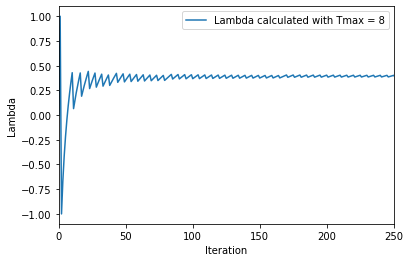

In [14]:
plt.plot(results[:,0])
plt.legend(["Lambda calculated with Tmax = 8"])
plt.xlabel("Iteration")
plt.ylabel("Lambda")
plt.xlim(0, 250)
plt.show()

# Results

# Using heuristical methods for gradient optimizations, we found the solution around 0.4 (we must remember that solution must complies all restrictions, by that, lambda values that are less than or equal to 0.4 with Tmax = 8 are not a solution due to time constraint)